In [57]:
import gc
import os
import joblib
import random
import warnings
import itertools
import scipy as sp
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from itertools import combinations
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.preprocessing import LabelEncoder
import warnings; warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold, train_test_split

def get_difference(data, num_features):
    df1 = []
    customer_ids = []
    for customer_id, df in tqdm(data.groupby(['customer_ID'])):
        diff_df1 = df[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    df1 = np.concatenate(df1, axis = 0)
    df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
    df1['customer_ID'] = customer_ids
    return df1

def read_preprocess_data():
    train = pd.read_parquet('train.parquet')
    features = train.drop(['customer_ID', 'S_2'], axis = 1).columns.to_list()
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    num_features = [col for col in features if col not in cat_features]
    print('Starting training feature engineer...')
    train_num_agg = train.groupby("customer_ID")[num_features].agg(['first', 'mean', 'std', 'min', 'max', 'last'])
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)

    # Lag Features
    for col in train_num_agg:
        if 'last' in col and col.replace('last', 'first') in train_num_agg:
            train_num_agg[col + '_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', 'first')]
            train_num_agg[col + '_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', 'first')]

    train_cat_agg = train.groupby("customer_ID")[cat_features].agg(['count', 'first', 'last', 'nunique'])
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    
    train_labels = pd.read_csv('train_labels.csv')
    # Transform float64 columns to float32
    cols = list(train_num_agg.dtypes[train_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        train_num_agg[col] = train_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(train_cat_agg.dtypes[train_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        train_cat_agg[col] = train_cat_agg[col].astype(np.int32)
    # Get the difference
    train_diff = get_difference(train, num_features)
    train = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_diff, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    del train_num_agg, train_cat_agg, train_diff
    gc.collect()
    
    # Test FE
    test = pd.read_parquet('test.parquet')
    print('Starting test feature engineer...')
    test_num_agg = test.groupby("customer_ID")[num_features].agg(['first', 'mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)

    # Lag Features
    for col in test_num_agg:
        if 'last' in col and col.replace('last', 'first') in test_num_agg:
            test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]
            test_num_agg[col + '_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', 'first')]

    test_cat_agg = test.groupby("customer_ID")[cat_features].agg(['count', 'first', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
    # Transform float64 columns to float32
    cols = list(test_num_agg.dtypes[test_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        test_num_agg[col] = test_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(test_cat_agg.dtypes[test_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        test_cat_agg[col] = test_cat_agg[col].astype(np.int32)
    # Get the difference
    test_diff = get_difference(test, num_features)
    test = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID').merge(test_diff, how = 'inner', on = 'customer_ID')
    del test_num_agg, test_cat_agg, test_diff
    gc.collect()
    # Save files to disk
    
# Read & Preprocess Data
# read_preprocess_data()

In [58]:
class CFG:
    seed = 42
    n_folds = 5
    target = 'target'

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def read_data():
    train = pd.read_parquet('train_fe_v3.parquet')
    test = pd.read_parquet('test_fe_v3.parquet')
    return train, test

def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

def amex_metric_np(preds, target):
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)
    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()
    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)
    g = gini / gini_max
    return 0.5 * (g + d)

In [6]:
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

def train_and_evaluate(train, test):
    # Label encode categorical features
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68"
    ]
    cat_features = [f"{cf}_last" for cf in cat_features]
    for cat_col in cat_features:
        encoder = LabelEncoder()
        train[cat_col] = encoder.fit_transform(train[cat_col])
        test[cat_col] = encoder.transform(test[cat_col])
    # Round last float features to 2 decimal place
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    num_cols = [col for col in num_cols if 'last' in col]
    for col in num_cols:
        train[col + '_round2'] = train[col].round(2)
        test[col + '_round2'] = test[col].round(2)
    # Get the difference between last and mean
    num_cols = [col for col in train.columns if 'last' in col]
    num_cols = [col[:-5] for col in num_cols if 'round' not in col]
    for col in num_cols:
        try:
            train[f'{col}_last_mean_diff'] = train[f'{col}_last'] - train[f'{col}_mean']
            test[f'{col}_last_mean_diff'] = test[f'{col}_last'] - test[f'{col}_mean']
        except:
            pass
    # Transform float64 and float32 to float16
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    for col in tqdm(num_cols):
        train[col] = train[col].astype(np.float16)
        test[col] = test[col].astype(np.float16)
    # Get feature list
    features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]
    params = {
        'objective': 'binary',
        'metric': "binary_logloss",
        'boosting': 'dart',
        'seed': CFG.seed,
        'num_leaves': 100,
        'learning_rate': 0.01,
        'feature_fraction': 0.20,
        'bagging_freq': 10,
        'bagging_fraction': 0.50,
        'n_jobs': -1,
        'lambda_l2': 2,
        'min_data_in_leaf': 40
        }
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
        lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
        lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
        model = lgb.train(
            params = params,
            train_set = lgb_train,
            num_boost_round = 10500,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 100,
            verbose_eval = 500,
            feval = lgb_amex_metric
            )
        # Save best model
        joblib.dump(model, f'lgbm_fold{fold}_seed{CFG.seed}_both.pkl')
        plt.figure(figsize=(20,15))
        lgb.plot_importance(model, max_num_features=20)
        plt.title("Featurertances")
        print(plt.show())
        # Predict validation
        val_pred = model.predict(x_val)
        # Add to out of folds array
        oof_predictions[val_ind] = val_pred
        # Predict the test set
        test_pred = model.predict(test[features])
        test_predictions += test_pred / CFG.n_folds
        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f'Our fold {fold} CV score is {score}')
        del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
        gc.collect()
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f'Our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(f'oof_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}_both.csv', index = False)
    # Create a dataframe to store test prediction
    test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
    test_df.to_csv(f'test_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}_both.csv', index = False)

In [7]:
seed_everything(CFG.seed)
train, test = read_data()
train_and_evaluate(train, test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1713/1713 [35:51<00:00,  1.26s/it]


 
--------------------------------------------------
Training fold 0 with 2177 features...
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.417493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 344989
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 2168
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[500]	training's binary_logloss: 0.33605	training's amex_metric: 0.778465	valid_1's binary_logloss: 0.338022	valid_1's amex_metric: 0.771528
[1000]	training's binary_logloss: 0.245286	training's amex_metric: 0.795263	valid_1's binary_logloss: 0.250998	valid_1's amex_metric: 0.780584
[1500]	training's binary_logloss: 0.221213	training's amex_metric: 0.809591	valid_1's binary_logloss: 0.230909	valid_1's a

[2000]	training's binary_logloss: 0.206684	training's amex_metric: 0.823912	valid_1's binary_logloss: 0.224494	valid_1's amex_metric: 0.789246
[2500]	training's binary_logloss: 0.199563	training's amex_metric: 0.834567	valid_1's binary_logloss: 0.221673	valid_1's amex_metric: 0.791973
[3000]	training's binary_logloss: 0.192421	training's amex_metric: 0.844502	valid_1's binary_logloss: 0.219463	valid_1's amex_metric: 0.793943
[3500]	training's binary_logloss: 0.185814	training's amex_metric: 0.855003	valid_1's binary_logloss: 0.218017	valid_1's amex_metric: 0.794612
[4000]	training's binary_logloss: 0.179961	training's amex_metric: 0.864905	valid_1's binary_logloss: 0.217189	valid_1's amex_metric: 0.796348
[4500]	training's binary_logloss: 0.174259	training's amex_metric: 0.874717	valid_1's binary_logloss: 0.216506	valid_1's amex_metric: 0.796708
[5000]	training's binary_logloss: 0.168611	training's amex_metric: 0.884086	valid_1's binary_logloss: 0.215998	valid_1's amex_metric: 0.797348

[5500]	training's binary_logloss: 0.164044	training's amex_metric: 0.892037	valid_1's binary_logloss: 0.214039	valid_1's amex_metric: 0.79906
[6000]	training's binary_logloss: 0.15975	training's amex_metric: 0.89966	valid_1's binary_logloss: 0.213795	valid_1's amex_metric: 0.798938
[6500]	training's binary_logloss: 0.155219	training's amex_metric: 0.907071	valid_1's binary_logloss: 0.213605	valid_1's amex_metric: 0.799191
[7000]	training's binary_logloss: 0.150015	training's amex_metric: 0.915028	valid_1's binary_logloss: 0.213307	valid_1's amex_metric: 0.799428
[7500]	training's binary_logloss: 0.14509	training's amex_metric: 0.922991	valid_1's binary_logloss: 0.213208	valid_1's amex_metric: 0.798983
[8000]	training's binary_logloss: 0.140723	training's amex_metric: 0.930469	valid_1's binary_logloss: 0.213131	valid_1's amex_metric: 0.798955
[8500]	training's binary_logloss: 0.136971	training's amex_metric: 0.936912	valid_1's binary_logloss: 0.213055	valid_1's amex_metric: 0.799823
[90

In [59]:
train, test = read_data()

In [60]:
train.shape

(458913, 1639)

In [61]:
features = [col for col in train.columns if col not in ['customer_ID', 'target']]
print(len(features))

1637


In [62]:
for i in features:
    print(i)

P_2_first
P_2_mean
P_2_std
P_2_min
P_2_max
P_2_last
D_39_first
D_39_mean
D_39_std
D_39_min
D_39_max
D_39_last
B_1_first
B_1_mean
B_1_std
B_1_min
B_1_max
B_1_last
B_2_first
B_2_mean
B_2_std
B_2_min
B_2_max
B_2_last
R_1_first
R_1_mean
R_1_std
R_1_min
R_1_max
R_1_last
S_3_first
S_3_mean
S_3_std
S_3_min
S_3_max
S_3_last
D_41_first
D_41_mean
D_41_std
D_41_min
D_41_max
D_41_last
B_3_first
B_3_mean
B_3_std
B_3_min
B_3_max
B_3_last
D_42_first
D_42_mean
D_42_std
D_42_min
D_42_max
D_42_last
D_43_first
D_43_mean
D_43_std
D_43_min
D_43_max
D_43_last
D_44_first
D_44_mean
D_44_std
D_44_min
D_44_max
D_44_last
B_4_first
B_4_mean
B_4_std
B_4_min
B_4_max
B_4_last
D_45_first
D_45_mean
D_45_std
D_45_min
D_45_max
D_45_last
B_5_first
B_5_mean
B_5_std
B_5_min
B_5_max
B_5_last
R_2_first
R_2_mean
R_2_std
R_2_min
R_2_max
R_2_last
D_46_first
D_46_mean
D_46_std
D_46_min
D_46_max
D_46_last
D_47_first
D_47_mean
D_47_std
D_47_min
D_47_max
D_47_last
D_48_first
D_48_mean
D_48_std
D_48_min
D_48_max
D_48_last
D_49_first

B_5_last_lag_div
R_2_last_lag_sub
R_2_last_lag_div
D_46_last_lag_sub
D_46_last_lag_div
D_47_last_lag_sub
D_47_last_lag_div
D_48_last_lag_sub
D_48_last_lag_div
D_49_last_lag_sub
D_49_last_lag_div
B_6_last_lag_sub
B_6_last_lag_div
B_7_last_lag_sub
B_7_last_lag_div
B_8_last_lag_sub
B_8_last_lag_div
D_50_last_lag_sub
D_50_last_lag_div
D_51_last_lag_sub
D_51_last_lag_div
B_9_last_lag_sub
B_9_last_lag_div
R_3_last_lag_sub
R_3_last_lag_div
D_52_last_lag_sub
D_52_last_lag_div
P_3_last_lag_sub
P_3_last_lag_div
B_10_last_lag_sub
B_10_last_lag_div
D_53_last_lag_sub
D_53_last_lag_div
S_5_last_lag_sub
S_5_last_lag_div
B_11_last_lag_sub
B_11_last_lag_div
S_6_last_lag_sub
S_6_last_lag_div
D_54_last_lag_sub
D_54_last_lag_div
R_4_last_lag_sub
R_4_last_lag_div
S_7_last_lag_sub
S_7_last_lag_div
B_12_last_lag_sub
B_12_last_lag_div
S_8_last_lag_sub
S_8_last_lag_div
D_55_last_lag_sub
D_55_last_lag_div
D_56_last_lag_sub
D_56_last_lag_div
B_13_last_lag_sub
B_13_last_lag_div
R_5_last_lag_sub
R_5_last_lag_div
D

In [63]:
cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68"
    ]
cat_features = [f"{cf}_last" for cf in cat_features]
for cat_col in cat_features:
    encoder = LabelEncoder()
    train[cat_col] = encoder.fit_transform(train[cat_col])
    test[cat_col] = encoder.transform(test[cat_col])
# Round last float features to 2 decimal place
num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
num_cols = [col for col in num_cols if 'last' in col and 'lag' not in col]
for col in num_cols:
    train[col + '_round2'] = train[col].round(2)
    test[col + '_round2'] = test[col].round(2)
# Get the difference between last and mean
num_cols = [col for col in train.columns if 'last' in col]
num_cols = [col[:-5] for col in num_cols if 'round' not in col]
for col in num_cols:
    try:
        train[f'{col}_last_mean_diff'] = train[f'{col}_last'] - train[f'{col}_mean']
        test[f'{col}_last_mean_diff'] = test[f'{col}_last'] - test[f'{col}_mean']
    except:
        pass
# Transform float64 and float32 to float16
num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
for col in tqdm(num_cols):
    train[col] = train[col].astype(np.float16)
    test[col] = test[col].astype(np.float16)
# Get feature list
features = [col for col in train.columns if col not in ['customer_ID', 'target']]
print(len(features))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1443/1443 [44:02<00:00,  1.83s/it]

1907


In [64]:
for i in features:
    print(i)

P_2_first
P_2_mean
P_2_std
P_2_min
P_2_max
P_2_last
D_39_first
D_39_mean
D_39_std
D_39_min
D_39_max
D_39_last
B_1_first
B_1_mean
B_1_std
B_1_min
B_1_max
B_1_last
B_2_first
B_2_mean
B_2_std
B_2_min
B_2_max
B_2_last
R_1_first
R_1_mean
R_1_std
R_1_min
R_1_max
R_1_last
S_3_first
S_3_mean
S_3_std
S_3_min
S_3_max
S_3_last
D_41_first
D_41_mean
D_41_std
D_41_min
D_41_max
D_41_last
B_3_first
B_3_mean
B_3_std
B_3_min
B_3_max
B_3_last
D_42_first
D_42_mean
D_42_std
D_42_min
D_42_max
D_42_last
D_43_first
D_43_mean
D_43_std
D_43_min
D_43_max
D_43_last
D_44_first
D_44_mean
D_44_std
D_44_min
D_44_max
D_44_last
B_4_first
B_4_mean
B_4_std
B_4_min
B_4_max
B_4_last
D_45_first
D_45_mean
D_45_std
D_45_min
D_45_max
D_45_last
B_5_first
B_5_mean
B_5_std
B_5_min
B_5_max
B_5_last
R_2_first
R_2_mean
R_2_std
R_2_min
R_2_max
R_2_last
D_46_first
D_46_mean
D_46_std
D_46_min
D_46_max
D_46_last
D_47_first
D_47_mean
D_47_std
D_47_min
D_47_max
D_47_last
D_48_first
D_48_mean
D_48_std
D_48_min
D_48_max
D_48_last
D_49_first

D_71_last_lag_sub
D_71_last_lag_div
D_72_last_lag_sub
D_72_last_lag_div
S_15_last_lag_sub
S_15_last_lag_div
B_23_last_lag_sub
B_23_last_lag_div
D_73_last_lag_sub
D_73_last_lag_div
P_4_last_lag_sub
P_4_last_lag_div
D_74_last_lag_sub
D_74_last_lag_div
D_75_last_lag_sub
D_75_last_lag_div
D_76_last_lag_sub
D_76_last_lag_div
B_24_last_lag_sub
B_24_last_lag_div
R_7_last_lag_sub
R_7_last_lag_div
D_77_last_lag_sub
D_77_last_lag_div
B_25_last_lag_sub
B_25_last_lag_div
B_26_last_lag_sub
B_26_last_lag_div
D_78_last_lag_sub
D_78_last_lag_div
D_79_last_lag_sub
D_79_last_lag_div
R_8_last_lag_sub
R_8_last_lag_div
R_9_last_lag_sub
R_9_last_lag_div
S_16_last_lag_sub
S_16_last_lag_div
D_80_last_lag_sub
D_80_last_lag_div
R_10_last_lag_sub
R_10_last_lag_div
R_11_last_lag_sub
R_11_last_lag_div
B_27_last_lag_sub
B_27_last_lag_div
D_81_last_lag_sub
D_81_last_lag_div
D_82_last_lag_sub
D_82_last_lag_div
S_17_last_lag_sub
S_17_last_lag_div
R_12_last_lag_sub
R_12_last_lag_div
B_28_last_lag_sub
B_28_last_lag_div


In [66]:
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

def train_and_evaluate(train, test):
    params = {
        'objective': 'binary',
        'metric': "binary_logloss",
        'boosting': 'dart',
        'seed': CFG.seed,
        'num_leaves': 100,
        'learning_rate': 0.01,
        'feature_fraction': 0.20,
        'bagging_freq': 10,
        'bagging_fraction': 0.50,
        'n_jobs': -1,
        'lambda_l2': 2,
        'min_data_in_leaf': 40
        }
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
        lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
        lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
        model = lgb.train(
            params = params,
            train_set = lgb_train,
            num_boost_round = 10500,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 100,
            verbose_eval = 500,
            feval = lgb_amex_metric
            )
        # Save best model
        joblib.dump(model, f'lgbm_fold{fold}_seed{CFG.seed}_both2.pkl')
        plt.figure(figsize=(20,15))
        lgb.plot_importance(model, max_num_features=20)
        plt.title("Featurertances")
        print(plt.show())
        # Predict validation
        val_pred = model.predict(x_val)
        # Add to out of folds array
        oof_predictions[val_ind] = val_pred
        # Predict the test set
        test_pred = model.predict(test[features])
        test_predictions += test_pred / CFG.n_folds
        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f'Our fold {fold} CV score is {score}')
        del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
        gc.collect()
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f'Our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(f'oof_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}_both2.csv', index = False)
    # Create a dataframe to store test prediction
    test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
    test_df.to_csv(f'test_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}_both2.csv', index = False) #Score: 0.798

 
--------------------------------------------------
Training fold 0 with 1907 features...
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.766952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302656
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 1898
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[500]	training's binary_logloss: 0.336113	training's amex_metric: 0.778742	valid_1's binary_logloss: 0.338102	valid_1's amex_metric: 0.771167
[1000]	training's binary_logloss: 0.245292	training's amex_metric: 0.794665	valid_1's binary_logloss: 0.250949	valid_1's amex_metric: 0.783186
[1500]	training's binary_logloss: 0.221184	training's amex_metric: 0.809179	valid_1's binary_logloss: 0.230869	valid_1's 

<Figure size 1440x1080 with 0 Axes>

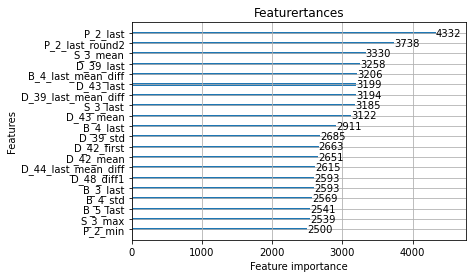

None
Our fold 0 CV score is 0.8031959344025701
 
--------------------------------------------------
Training fold 1 with 1907 features...
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.544987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302809
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 1898
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[500]	training's binary_logloss: 0.335863	training's amex_metric: 0.78052	valid_1's binary_logloss: 0.339114	valid_1's amex_metric: 0.763943
[1000]	training's binary_logloss: 0.244713	training's amex_metric: 0.797485	valid_1's binary_logloss: 0.252606	valid_1's amex_metric: 0.773683
[1500]	training's binary_logloss: 0.220427	training's amex_metric: 0.811018

<Figure size 1440x1080 with 0 Axes>

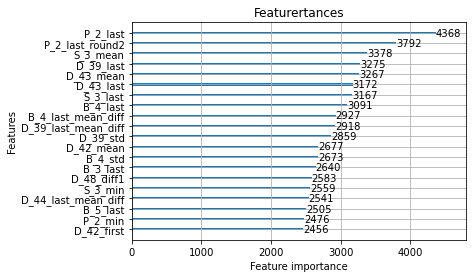

None
Our fold 1 CV score is 0.7941693178959548
 
--------------------------------------------------
Training fold 2 with 1907 features...
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.353003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302696
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 1898
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[500]	training's binary_logloss: 0.335759	training's amex_metric: 0.779834	valid_1's binary_logloss: 0.339483	valid_1's amex_metric: 0.767952
[1000]	training's binary_logloss: 0.244657	training's amex_metric: 0.796025	valid_1's binary_logloss: 0.252929	valid_1's amex_metric: 0.778167
[1500]	training's binary_logloss: 0.22053	training's amex_metric: 0.809664

<Figure size 1440x1080 with 0 Axes>

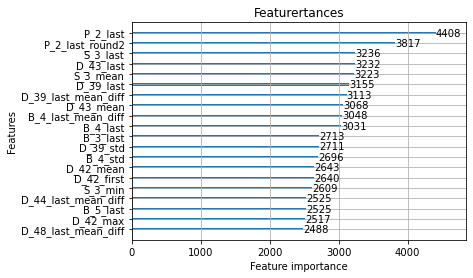

None
Our fold 2 CV score is 0.7981457352976373
 
--------------------------------------------------
Training fold 3 with 1907 features...
[LightGBM] [Info] Number of positive: 95063, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.362358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302694
[LightGBM] [Info] Number of data points in the train set: 367131, number of used features: 1898
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258935 -> initscore=-1.051512
[LightGBM] [Info] Start training from score -1.051512
[500]	training's binary_logloss: 0.335465	training's amex_metric: 0.780384	valid_1's binary_logloss: 0.340341	valid_1's amex_metric: 0.763507
[1000]	training's binary_logloss: 0.24442	training's amex_metric: 0.797236	valid_1's binary_logloss: 0.253997	valid_1's amex_metric: 0.773046
[1500]	training's binary_logloss: 0.220231	training's amex_metric: 0.81178	

<Figure size 1440x1080 with 0 Axes>

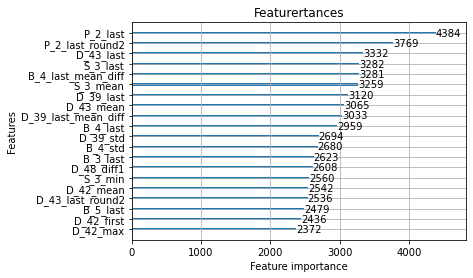

None
Our fold 3 CV score is 0.7941276521247966
 
--------------------------------------------------
Training fold 4 with 1907 features...
[LightGBM] [Info] Number of positive: 95063, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.638972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302743
[LightGBM] [Info] Number of data points in the train set: 367131, number of used features: 1898
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258935 -> initscore=-1.051512
[LightGBM] [Info] Start training from score -1.051512
[500]	training's binary_logloss: 0.336102	training's amex_metric: 0.778609	valid_1's binary_logloss: 0.33906	valid_1's amex_metric: 0.767993
[1000]	training's binary_logloss: 0.245125	training's amex_metric: 0.795933	valid_1's binary_logloss: 0.252009	valid_1's amex_metric: 0.778521
[1500]	training's binary_logloss: 0.220995	training's amex_metric: 0.810061

<Figure size 1440x1080 with 0 Axes>

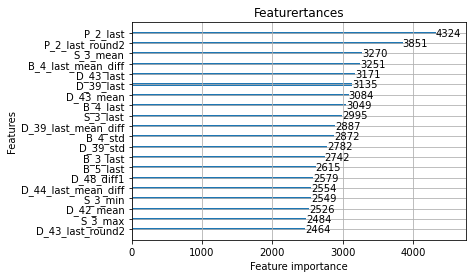

None
Our fold 4 CV score is 0.7992630531638345
Our out of folds CV score is 0.7976965366244495


In [67]:
seed_everything(CFG.seed)
train_and_evaluate(train, test)

In [37]:
import gc
import os
import joblib
import random
import warnings
import itertools
import scipy as sp
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from itertools import combinations
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.preprocessing import LabelEncoder
import warnings; warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold, train_test_split

def get_difference(data, num_features):
    df1 = []
    customer_ids = []
    for customer_id, df in tqdm(data.groupby(['customer_ID'])):
        diff_df1 = df[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    df1 = np.concatenate(df1, axis = 0)
    df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
    df1['customer_ID'] = customer_ids
    return df1

def read_preprocess_data():
    train = pd.read_parquet('/Users/shuozhang/Downloads/train.parquet')
    features = train.drop(['customer_ID', 'S_2'], axis = 1).columns.to_list()
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    num_features = [col for col in features if col not in cat_features]
    print('Starting training feature engineer...')
    train_num_agg = train.groupby("customer_ID")[num_features].agg(['first', 'mean', 'std', 'min', 'max', 'last'])
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)

    # Lag Features
    for col in train_num_agg:
        for col_2 in ['first']:
            if 'last' in col and col.replace('last', col_2) in train_num_agg:
                train_num_agg[col + '_first_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', col_2)]
                train_num_agg[col + '_first_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', col_2)]
    for col in train_num_agg:
        for col_2 in ['mean']:
            if 'last' in col and col.replace('last', col_2) in train_num_agg:
                train_num_agg[col + '_mean_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', col_2)]
                train_num_agg[col + '_mean_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', col_2)]            
    for col in train_num_agg:
        for col_2 in ['min']:
            if 'last' in col and col.replace('last', col_2) in train_num_agg:
                train_num_agg[col + '_min_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', col_2)]
                train_num_agg[col + '_min_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', col_2)]
    for col in train_num_agg:
        for col_2 in ['max']:
            if 'last' in col and col.replace('last', col_2) in train_num_agg:
                train_num_agg[col + '_max_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', col_2)]
                train_num_agg[col + '_max_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', col_2)]    
    
    train_cat_agg = train.groupby("customer_ID")[cat_features].agg(['count', 'first', 'last', 'nunique'])
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    train_labels = pd.read_csv('train_labels.csv')
    # Transform float64 columns to float32
    cols = list(train_num_agg.dtypes[train_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        train_num_agg[col] = train_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(train_cat_agg.dtypes[train_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        train_cat_agg[col] = train_cat_agg[col].astype(np.int32)
    # Get the difference
    train_diff = get_difference(train, num_features)
    train = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_diff, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    del train_num_agg, train_cat_agg, train_diff
    gc.collect()
    test = pd.read_parquet('/Users/shuozhang/Downloads/test.parquet')
    print('Starting test feature engineer...')
    test_num_agg = test.groupby("customer_ID")[num_features].agg(['first', 'mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)

    # Lag Features
    for col in test_num_agg:
        for col_2 in ['first']:
            if 'last' in col and col.replace('last', col_2) in test_num_agg:
                test_num_agg[col + '_first_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', col_2)]
                test_num_agg[col + '_first_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', col_2)]
    for col in test_num_agg:
        for col_2 in [ 'mean']:
            if 'last' in col and col.replace('last', col_2) in test_num_agg:
                test_num_agg[col +'_mean_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', col_2)]
                test_num_agg[col +'_mean_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', col_2)]
    for col in test_num_agg:
        for col_2 in [ 'min']:
            if 'last' in col and col.replace('last', col_2) in test_num_agg:
                test_num_agg[col +'_min_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', col_2)]
                test_num_agg[col +'_min_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', col_2)]
    for col in test_num_agg:
        for col_2 in [ 'max']:
            if 'last' in col and col.replace('last', col_2) in test_num_agg:
                test_num_agg[col + '_max_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', col_2)]
                test_num_agg[col + '_max_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', col_2)]

    test_cat_agg = test.groupby("customer_ID")[cat_features].agg(['count', 'first', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
    # Transform float64 columns to float32
    cols = list(test_num_agg.dtypes[test_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        test_num_agg[col] = test_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(test_cat_agg.dtypes[test_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        test_cat_agg[col] = test_cat_agg[col].astype(np.int32)
    # Get the difference
    test_diff = get_difference(test, num_features)
    test = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID').merge(test_diff, how = 'inner', on = 'customer_ID')
    del test_num_agg, test_cat_agg, test_diff
    gc.collect()
    return train, test
train,test=read_preprocess_data()

Starting training feature engineer...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 458913/458913 [06:42<00:00, 1139.53it/s]


Starting test feature engineer...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 924621/924621 [14:05<00:00, 1093.94it/s]


In [38]:
features = [col for col in train.columns if col not in ['customer_ID', 'target']]
print(len(features))

2699


In [41]:
cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68"
    ]
cat_features = [f"{cf}_last" for cf in cat_features]
for cat_col in cat_features:
    encoder = LabelEncoder()
    train[cat_col] = encoder.fit_transform(train[cat_col])
    test[cat_col] = encoder.transform(test[cat_col])
# Round last float features to 2 decimal place
num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
num_cols = [col for col in num_cols if 'last' in col and 'lag' not in col ]
for col in num_cols:
    train[col + '_round2'] = train[col].round(2)
    test[col + '_round2'] = test[col].round(2)
# Transform float64 and float32 to float16
num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
for col in tqdm(num_cols):
    train[col] = train[col].astype(np.float16)
    test[col] = test[col].astype(np.float16)
# Get feature list
features = [col for col in train.columns if col not in ['customer_ID', 'target']]
print(len(features))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2160/2160 [01:03<00:00, 33.80it/s]

2792


In [43]:
class CFG:
    seed = 42
    n_folds = 5
    target = 'target'

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

def amex_metric_np(preds, target):
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)
    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()
    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)
    g = gini / gini_max
    return 0.5 * (g + d)

In [49]:
import matplotlib.pyplot as plt

In [51]:
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

def train_and_evaluate(train, test):
    params = {
        'objective': 'binary',
        'metric': "binary_logloss",
        'boosting': 'dart',
        'seed': CFG.seed,
        'num_leaves': 100,
        'learning_rate': 0.01,
        'feature_fraction': 0.20,
        'bagging_freq': 10,
        'bagging_fraction': 0.50,
        'n_jobs': -1,
        'lambda_l2': 2,
        'min_data_in_leaf': 40
        }
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
        lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
        lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
        model = lgb.train(
            params = params,
            train_set = lgb_train,
            num_boost_round = 10500,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 100,
            verbose_eval = 500,
            feval = lgb_amex_metric
            )
        # Save best model
        joblib.dump(model, f'lgbm_fold{fold}_seed{CFG.seed}_brute.pkl')
        plt.figure(figsize=(20,15))
        lgb.plot_importance(model, max_num_features=20)
        plt.title("Featurertances")
        print(plt.show())
        # Predict validation
        val_pred = model.predict(x_val)
        # Add to out of folds array
        oof_predictions[val_ind] = val_pred
        # Predict the test set
        test_pred = model.predict(test[features])
        test_predictions += test_pred / CFG.n_folds
        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f'Our fold {fold} CV score is {score}')
        del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
        gc.collect()
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f'Our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(f'oof_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}_brute.csv', index = False)
    # Create a dataframe to store test prediction
    test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
    test_df.to_csv(f'test_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}_brute.csv', index = False)


 
--------------------------------------------------
Training fold 0 with 2792 features...
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.561384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 438324
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 2781
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[500]	training's binary_logloss: 0.335856	training's amex_metric: 0.779265	valid_1's binary_logloss: 0.338005	valid_1's amex_metric: 0.771163
[1000]	training's binary_logloss: 0.244821	training's amex_metric: 0.796535	valid_1's binary_logloss: 0.250757	valid_1's amex_metric: 0.782518
[1500]	training's binary_logloss: 0.220665	training's amex_metric: 0.81088	valid_1's binary_logloss: 0.230796	valid_1's a

<Figure size 1440x1080 with 0 Axes>

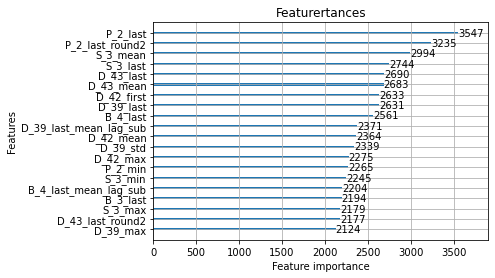

None
Our fold 0 CV score is 0.8027675951185322
 
--------------------------------------------------
Training fold 1 with 2792 features...
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 13.188171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 438545
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 2781
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[500]	training's binary_logloss: 0.335513	training's amex_metric: 0.780915	valid_1's binary_logloss: 0.338913	valid_1's amex_metric: 0.765065
[1000]	training's binary_logloss: 0.244189	training's amex_metric: 0.798521	valid_1's binary_logloss: 0.252402	valid_1's amex_metric: 0.774577
[1500]	training's binary_logloss: 0.21989	training's amex_metric: 0.81254

<Figure size 1440x1080 with 0 Axes>

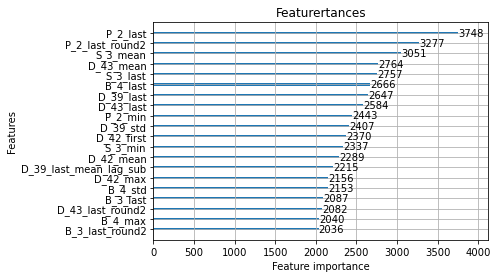

None
Our fold 1 CV score is 0.7944382831991139
 
--------------------------------------------------
Training fold 2 with 2792 features...
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.669493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 438383
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 2781
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[500]	training's binary_logloss: 0.33543	training's amex_metric: 0.779639	valid_1's binary_logloss: 0.339355	valid_1's amex_metric: 0.768056
[1000]	training's binary_logloss: 0.244164	training's amex_metric: 0.797355	valid_1's binary_logloss: 0.252778	valid_1's amex_metric: 0.778654
[1500]	training's binary_logloss: 0.219986	training's amex_metric: 0.811428

<Figure size 1440x1080 with 0 Axes>

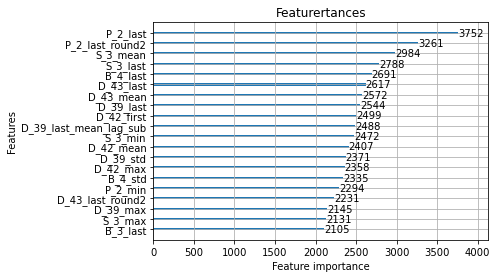

None
Our fold 2 CV score is 0.7976423978932887
 
--------------------------------------------------
Training fold 3 with 2792 features...
[LightGBM] [Info] Number of positive: 95063, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.747642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 438385
[LightGBM] [Info] Number of data points in the train set: 367131, number of used features: 2781
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258935 -> initscore=-1.051512
[LightGBM] [Info] Start training from score -1.051512
[500]	training's binary_logloss: 0.335187	training's amex_metric: 0.780697	valid_1's binary_logloss: 0.340122	valid_1's amex_metric: 0.76278
[1000]	training's binary_logloss: 0.243929	training's amex_metric: 0.798244	valid_1's binary_logloss: 0.253712	valid_1's amex_metric: 0.773629
[1500]	training's binary_logloss: 0.21977	training's amex_metric: 0.811856	

<Figure size 1440x1080 with 0 Axes>

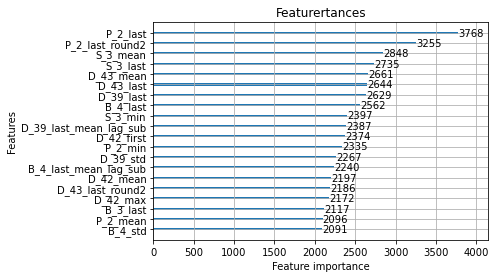

None
Our fold 3 CV score is 0.7932900440005286
 
--------------------------------------------------
Training fold 4 with 2792 features...
[LightGBM] [Info] Number of positive: 95063, number of negative: 272068
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.003332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 438492
[LightGBM] [Info] Number of data points in the train set: 367131, number of used features: 2781
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258935 -> initscore=-1.051512
[LightGBM] [Info] Start training from score -1.051512
[500]	training's binary_logloss: 0.335709	training's amex_metric: 0.779899	valid_1's binary_logloss: 0.338792	valid_1's amex_metric: 0.768945
[1000]	training's binary_logloss: 0.244672	training's amex_metric: 0.796764	valid_1's binary_logloss: 0.251719	valid_1's amex_metric: 0.778877
[1500]	training's binary_logloss: 0.220526	training's amex_metric: 0.81159

<Figure size 1440x1080 with 0 Axes>

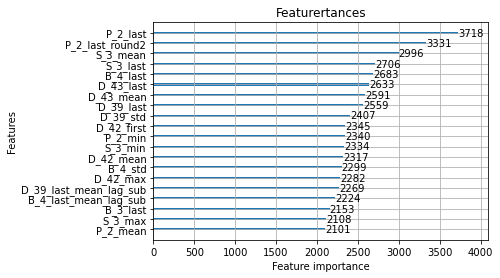

None
Our fold 4 CV score is 0.7990148702382691
Our out of folds CV score is 0.7972239492893989


In [52]:
seed_everything(CFG.seed)
train_and_evaluate(train, test)

In [55]:
train.shape

(458913, 2794)

In [ ]:
# train.to_pickle('train_brute.pkl', compression='gzip')
# test.to_pickle('test_brute.pkl', compression='gzip')